# Telco Churn – Scratch Pad

Freeform exploration—nothing here is production-ready.

# 1.0 Imports & Config

In [ ]:
# -------------------------------
# 1. Core data manipulation
# -------------------------------
import numpy as np
import pandas as pd

# -------------------------------
# 2. Exploratory visualization
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 3. Pre-processing and validation
# -------------------------------
from typing import Tuple, List
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

# -------------------------------
# 4. Essential churn-prediction models
# -------------------------------
from sklearn.linear_model import LogisticRegression          # interpretable baseline
from sklearn.tree import DecisionTreeClassifier              # simple tree
from sklearn.ensemble import (
    RandomForestClassifier,                                   # bagging ensemble
    GradientBoostingClassifier,                               # classic boosting
    AdaBoostClassifier,                                       # adaptive boosting
)
from sklearn.svm import SVC                                   # support-vector classifier
from sklearn.neighbors import KNeighborsClassifier            # k-nearest neighbors
from xgboost import XGBClassifier                             # gradient boosting, fast
from lightgbm import LGBMClassifier                           # gradient boosting, cat-friendly
from catboost import CatBoostClassifier                       # handles categorical vars natively

# -------------------------------
# 5. Evaluation metrics & plots
# -------------------------------
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_recall_curve,
)

# -------------------------------
# 6. Model interpretability and optimization
# -------------------------------
import shap                                                   # SHAP values for global/local explanations
import tuning_shap
from typing import Dict, List, Tuple
import joblib

# -------------------------------
# 7. Categorical vs. binary-target association
# -------------------------------
import math
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest


In [2]:
# display all columns in notebook, truncate rows for readability
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 25)

RANDOM_STATE = 42

In [3]:
DATA_PATH    = '/home/sidnei/repos/telco_churn_case/data/telco_churn_case_data.csv'  

# 2.0 Data Load

In [180]:
# src/data_io.py
def load_raw(path: str) -> pd.DataFrame:
    "Load csv and strip whitespace from string columns."
    df = pd.read_csv(path)
    str_cols = df.select_dtypes("object").columns
    df[str_cols] = df[str_cols].apply(lambda s: s.str.strip())
    return df

In [198]:
# src/eda.py
def full_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a tidy table with every column and its dtype.
    Never truncates, so you always see all 21 columns.
    """
    return (
        pd.DataFrame({"column": df.columns, "dtype": df.dtypes.astype(str)})
        .reset_index(drop=True)
    )

def describe_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Columns with NA count > 0, sorted by count.
    If the result is empty, the caller can decide to print a
    'No missing values' message.
    """
    out = (
        df.isna().sum()
          .to_frame("missing")
          .assign(pct=lambda d: d["missing"] / len(df))
          .query("missing > 0")
          .sort_values("missing", ascending=False)
    )
    return out

def unique_summary(
    df: pd.DataFrame,
    max_show: int = 10,
    numeric_bins: bool = False,
    bin_quantiles: tuple = (0, 0.25, 0.5, 0.75, 1),
) -> pd.DataFrame:
    """
    Summary of *all* columns (numeric & object):
    ─ column
    ─ dtype
    ─ n_unique
    ─ sample_values  (or quantile summary if numeric_bins=True & high cardinality)

    Parameters
    ----------
    max_show : int
        Max number of unique examples to display before adding '…'.
    numeric_bins : bool
        If True, numeric cols with high cardinality get a quantile
        summary instead of listing raw values.
    bin_quantiles : tuple
        Quantiles used when numeric_bins is True.

    Returns
    -------
    pd.DataFrame sorted by n_unique descending.
    """
    rows = []
    for col in df.columns:
        ser = df[col].dropna()
        n_unique = ser.nunique()
        dtype = ser.dtype.name

        if pd.api.types.is_numeric_dtype(ser) and numeric_bins and n_unique > 50:
            qs = ser.quantile(bin_quantiles).round(2).tolist()
            sample = f"quantiles={qs}"
        else:
            uniques = ser.unique()[:max_show]
            sample = ", ".join(map(str, uniques))
            if n_unique > max_show:
                sample += ", …"

        rows.append(
            {
                "column": col,
                "dtype": dtype,
                "n_unique": n_unique,
                "sample_values": sample,
            }
        )

    return (
        pd.DataFrame(rows)
        .sort_values("n_unique", ascending=False)
        .reset_index(drop=True)
    )

In [199]:
df = load_raw(DATA_PATH)
print(df.shape)          # -> rows, columns
display(df.head())

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [204]:
display(full_dtypes(df))

,column,dtype
0,customerID,object
1,gender,object
2,SeniorCitizen,int8
3,Partner,object
4,Dependents,object
5,tenure,int64
6,PhoneService,object
7,MultipleLines,object
8,InternetService,object
9,OnlineSecurity,object


In [201]:
# Missing-value scan
mis = describe_missing(df)
if mis.empty:
    print("✅ No missing values detected.")
else:
    display(mis)


✅ No missing values detected.


In [202]:
# Quick look at unique values for all object columns
display(unique_summary(df, max_show=5))

,column,dtype,n_unique,sample_values
0,customerID,object,7043,"7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOCW..."
1,TotalCharges,object,6531,"29.85, 1889.5, 108.15, 1840.75, 151.65, …"
2,MonthlyCharges,float64,1585,"29.85, 56.95, 53.85, 42.3, 70.7, …"
3,tenure,int64,73,"1, 34, 2, 45, 8, …"
4,PaymentMethod,object,4,"Electronic check, Mailed check, Bank transfer ..."
5,StreamingMovies,object,3,"No, Yes, No internet service"
6,TechSupport,object,3,"No, Yes, No internet service"
7,OnlineBackup,object,3,"Yes, No, No internet service"
8,StreamingTV,object,3,"No, Yes, No internet service"
9,DeviceProtection,object,3,"No, Yes, No internet service"


In [203]:
def clean_basic(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Convert TotalCharges; coerce errors -> NaN to fix blanks
    df["TotalCharges"] = (
        df["TotalCharges"]
          .replace(r"^\s*$", np.nan, regex=True)
          .astype("float64")
    )
    
    df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)
    
    # SeniorCitizen is 0/1 -> categorical flag
    df["SeniorCitizen"] = df["SeniorCitizen"].astype("int8")

    # mark target as 1/0
    df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype("int8")
    return df

df = clean_basic(df)

# 3.0 Exploratory Data Analysis

In [11]:
NUM_COLS = ["tenure", "MonthlyCharges", "TotalCharges"]
CAT_COLS = [c for c in df.columns if c not in NUM_COLS + ["Churn", "customerID"]]

In [197]:
df[NUM_COLS].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


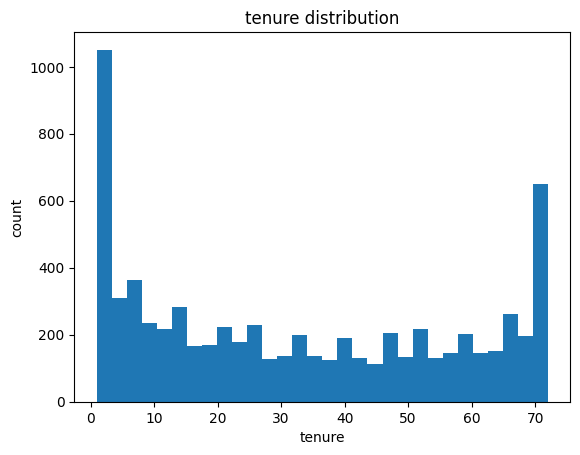

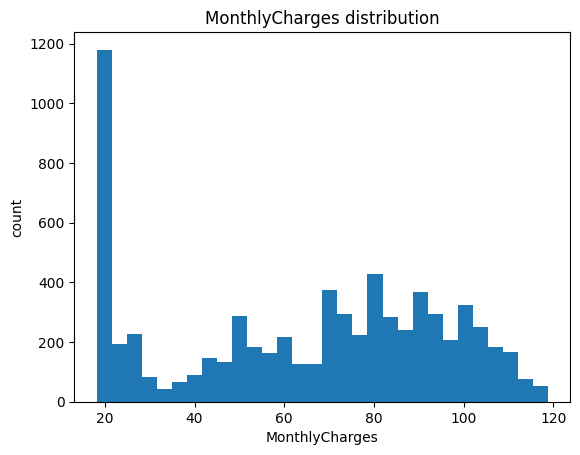

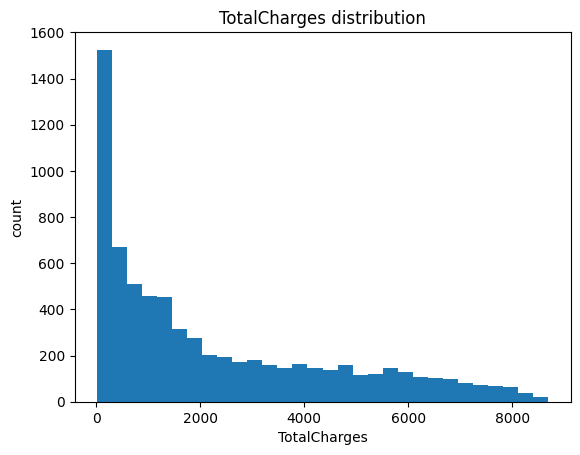

In [13]:
for col in NUM_COLS:
    plt.figure(); plt.hist(df[col].dropna(), bins=30)
    plt.title(f"{col} distribution"); plt.xlabel(col); plt.ylabel("count")

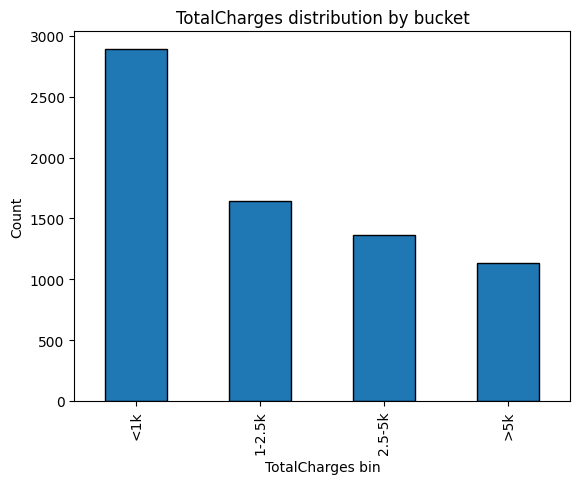

In [14]:
df["TotalCharges_bin"] = pd.cut(df["TotalCharges"], bins=[0, 1000, 2500, 5000, np.inf],
                                labels=["<1k","1-2.5k","2.5-5k",">5k"])

#df["TotalCharges_bin"].value_counts().sort_index()

df["TotalCharges_bin"].value_counts().sort_index().plot(
    kind="bar", edgecolor="black"
)

plt.title("TotalCharges distribution by bucket")
plt.xlabel("TotalCharges bin")
plt.ylabel("Count")
plt.show()


<Axes: xlabel='InternetService'>

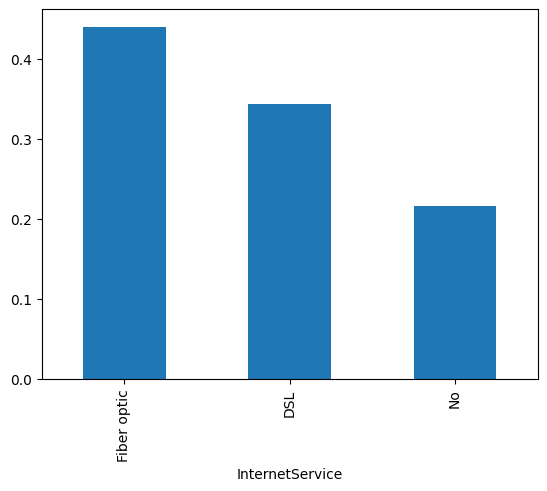

In [15]:
df["InternetService"].value_counts(normalize=True).plot.bar()

<Figure size 640x480 with 0 Axes>

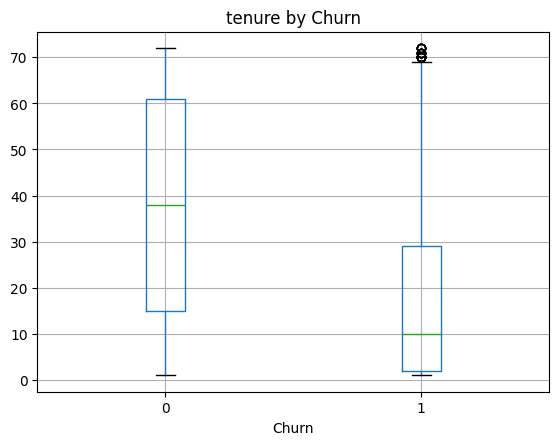

<Figure size 640x480 with 0 Axes>

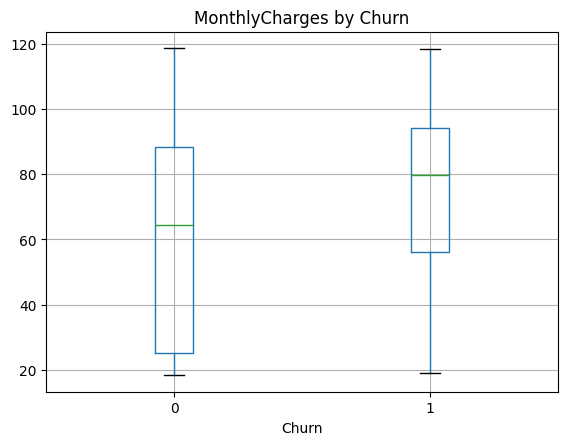

<Figure size 640x480 with 0 Axes>

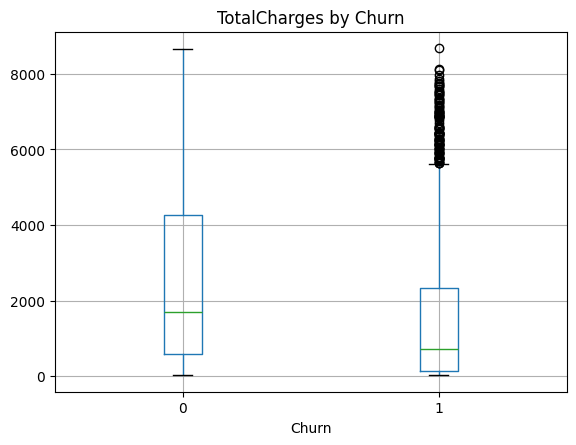

In [16]:
# Numeric vs target
for col in NUM_COLS:
    plt.figure()
    df.boxplot(column=col, by="Churn")
    plt.title(f"{col} by Churn")
    plt.suptitle("")
    plt.show()


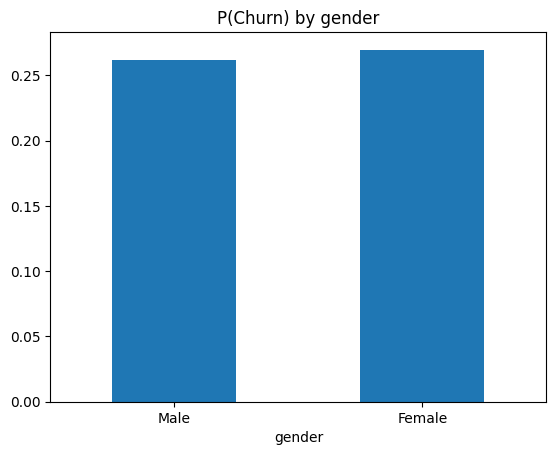

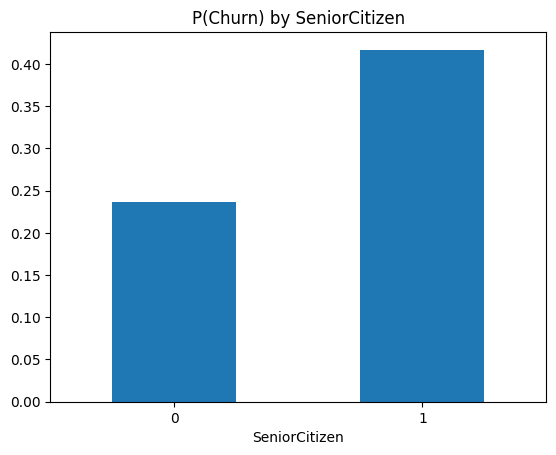

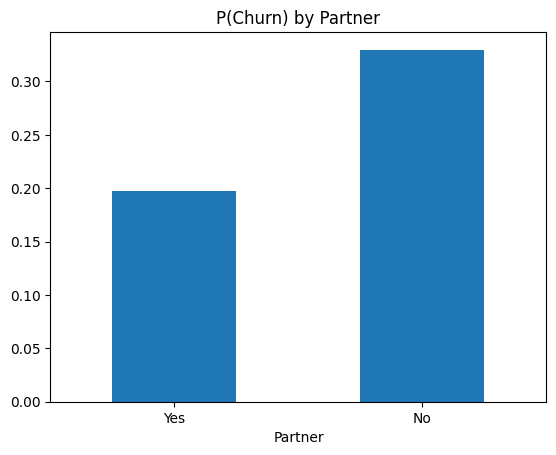

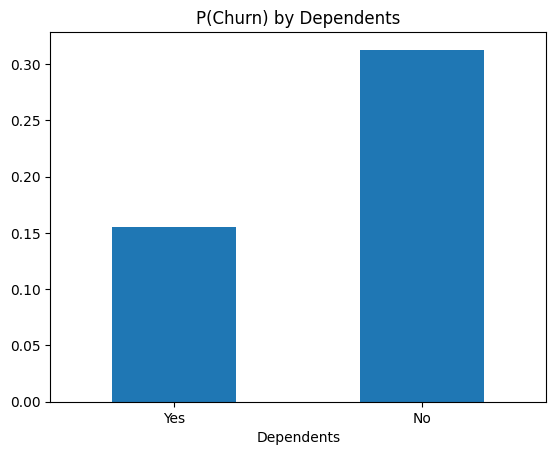

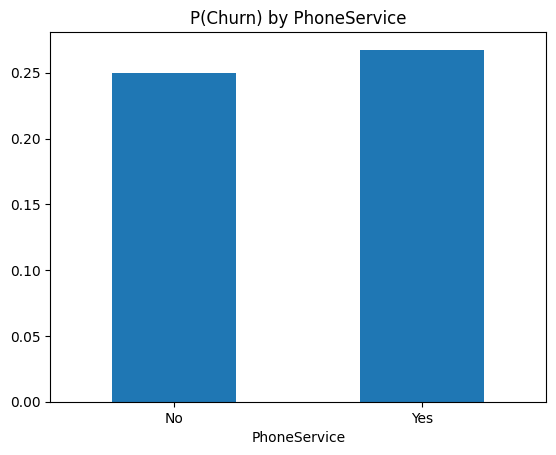

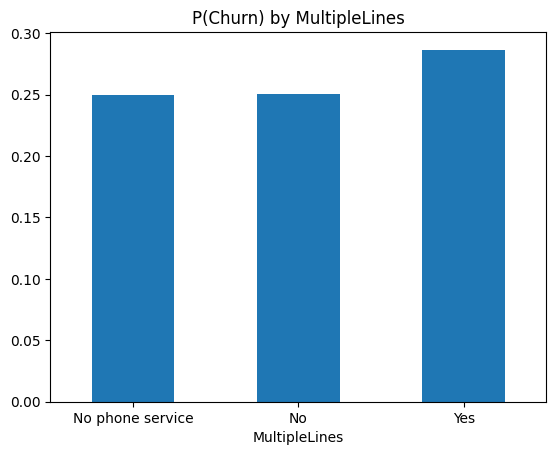

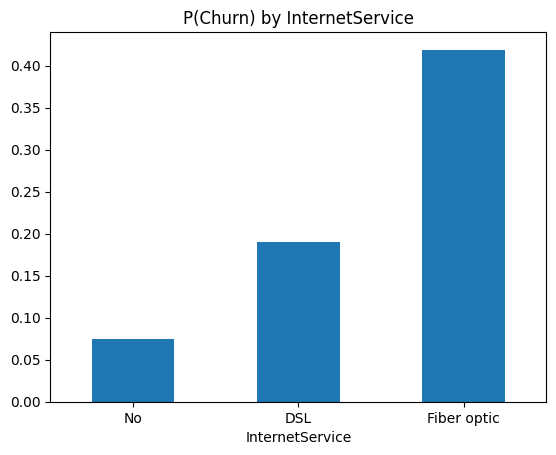

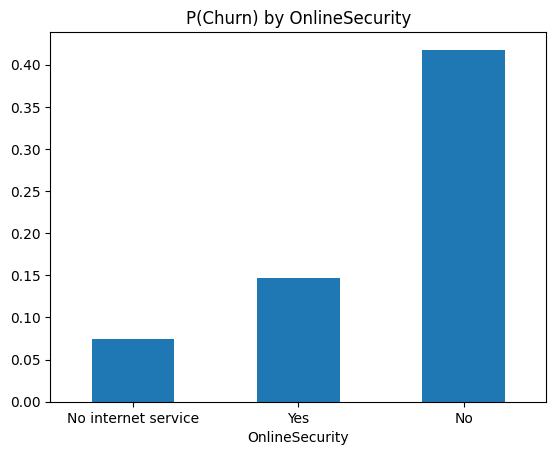

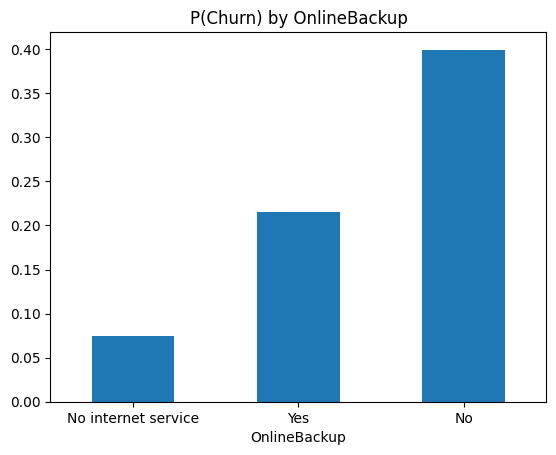

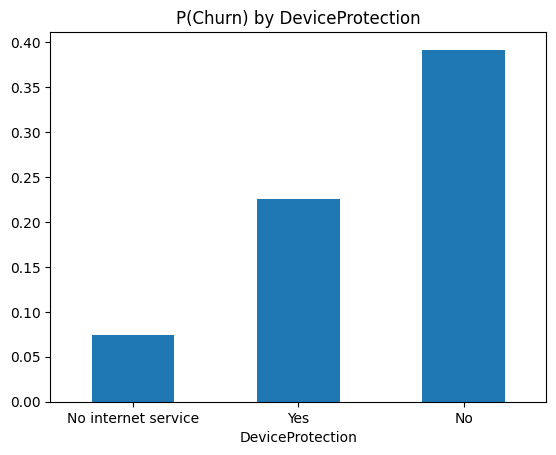

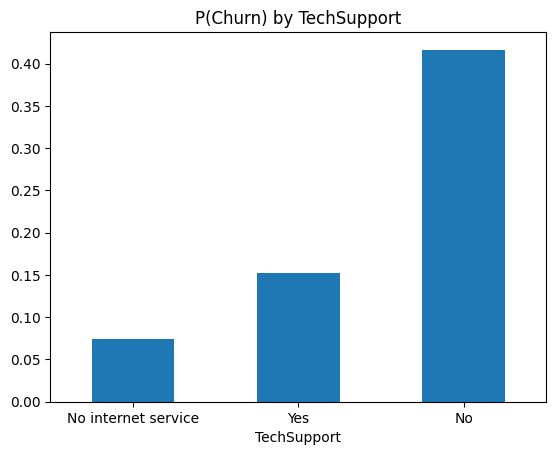

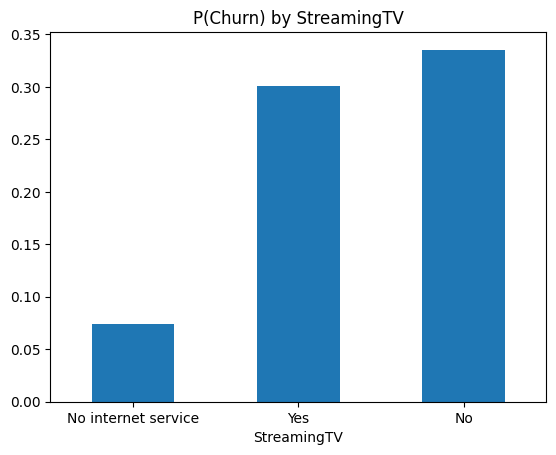

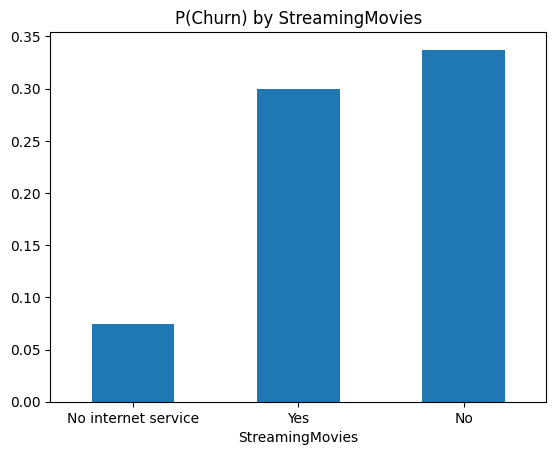

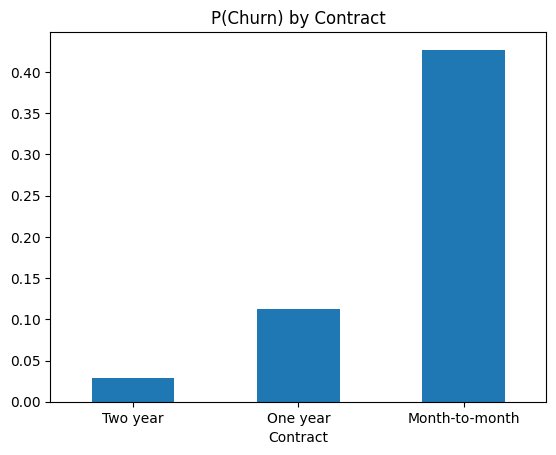

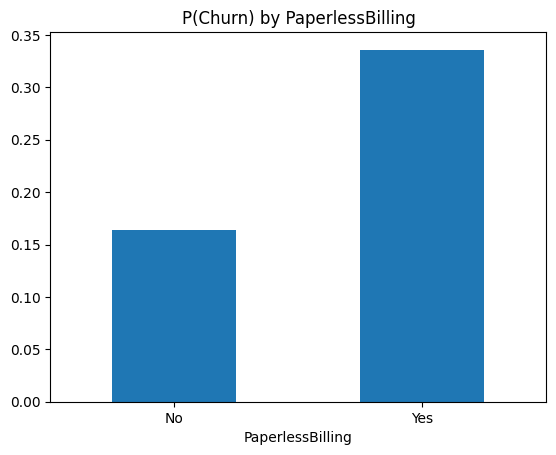

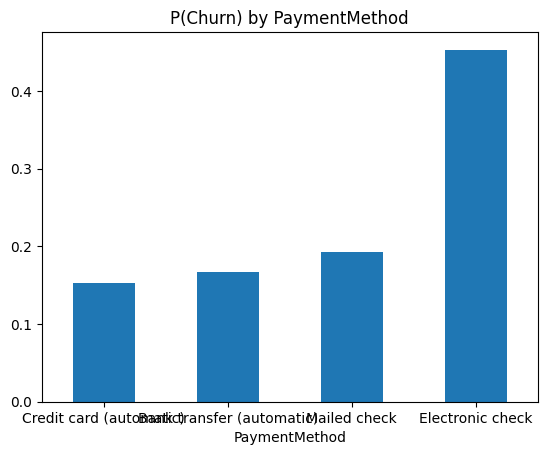

In [17]:
# Categorical vs target (stacked % bars)
for col in CAT_COLS:
    (df.groupby(col)["Churn"]
       .mean()
       .sort_values()
       .plot(kind="bar", rot=0, title=f"P(Churn) by {col}"))
    plt.show()

In [18]:
def plot_bucket_distribution(series: pd.Series, bins: list, labels: list = None, title: str = None):
    """
    Create bins for a numeric series and plot bucket distribution.
    Returns the binned Series.
    """
    binned = pd.cut(series, bins=bins, labels=labels)

    binned.value_counts().sort_index().plot(
        kind="bar", edgecolor="black"
    )
    plt.title(title if title else f"{series.name} distribution by bucket")
    plt.xlabel(series.name + " bin")
    plt.ylabel("Count")
    plt.show()

    return binned

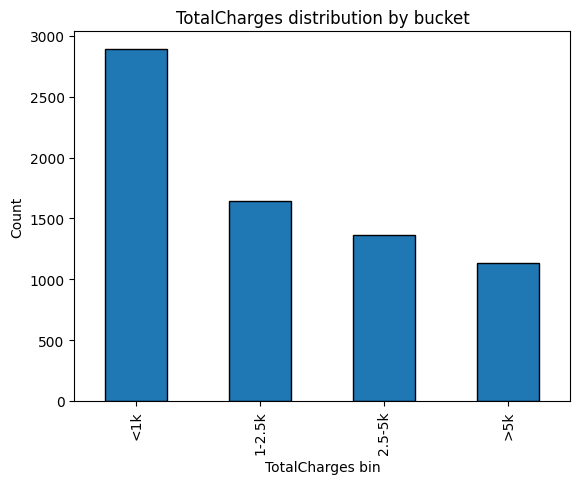

In [19]:
df["TotalCharges_bin"] = plot_bucket_distribution(
    df["TotalCharges"],
    bins=[0, 1000, 2500, 5000, np.inf],
    labels=["<1k", "1-2.5k", "2.5-5k", ">5k"],
    title="TotalCharges distribution by bucket"
)

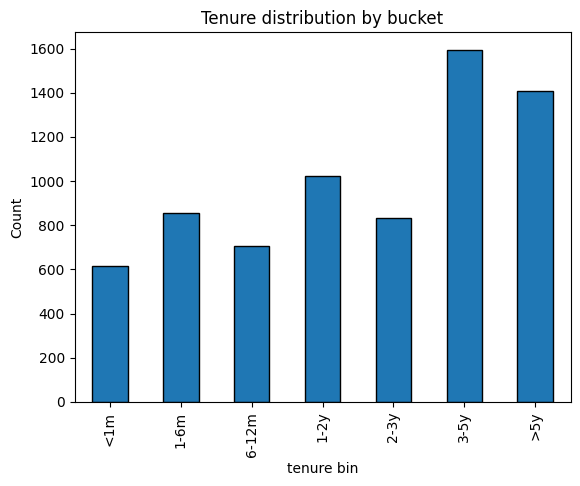

In [20]:
df["tenure_bin"] = plot_bucket_distribution(
    df["tenure"],
    bins=[0, 1, 6, 12, 24, 36, 60, np.inf],
    labels=["<1m", "1-6m", "6-12m", "1-2y", "2-3y", "3-5y", ">5y"],
    title="Tenure distribution by bucket"
)


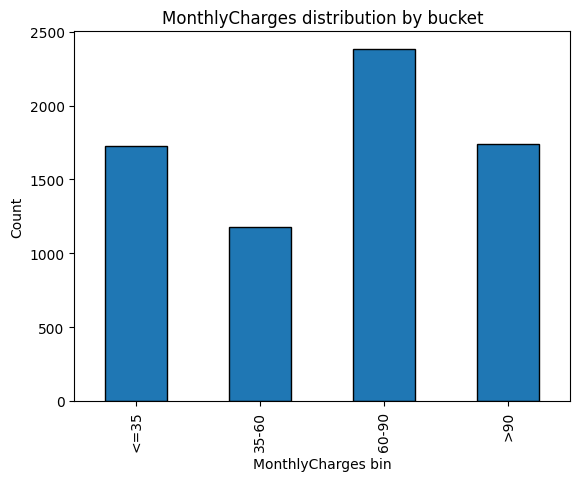

In [21]:
df["MonthlyCharges_bin"] = plot_bucket_distribution(
    df["MonthlyCharges"],
    bins=[0, 35, 60, 90, np.inf],
    labels=["<=35", "35-60", "60-90", ">90"],
    title="MonthlyCharges distribution by bucket"
)


In [22]:
def plot_churn_rate_by_bin(df, bin_col: str, target_col: str = "Churn"):
    """
    Plot the churn rate (percentage) for each bin or category.
    Display the churn rate value on top of each bar.

    Parameters:
    - df: pandas DataFrame
    - bin_col: column name of the bin or categorical variable 
               (e.g., 'TotalCharges_bin', 'tenure_bin')
    - target_col: binary target variable (default = 'Churn')

    Returns:
    - pandas Series with churn rate by bin
    """
    churn_rate = (
        df.groupby(bin_col)[target_col]
          .mean()
          .sort_index()
    )

    ax = churn_rate.plot(kind="bar", edgecolor="black")

    plt.title(f"{target_col} Rate by {bin_col}")
    plt.xlabel(bin_col)
    plt.ylabel(f"{target_col} Rate")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Add labels on top of bars
    for idx, value in enumerate(churn_rate):
        plt.text(
            x=idx,
            y=value + 0.02,  # slightly above the bar
            s=f"{value:.2f}",
            ha="center",
            fontweight="bold"
        )

    plt.show()

    return churn_rate

/tmp/ipykernel_1444/2287798146.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(bin_col)[target_col]


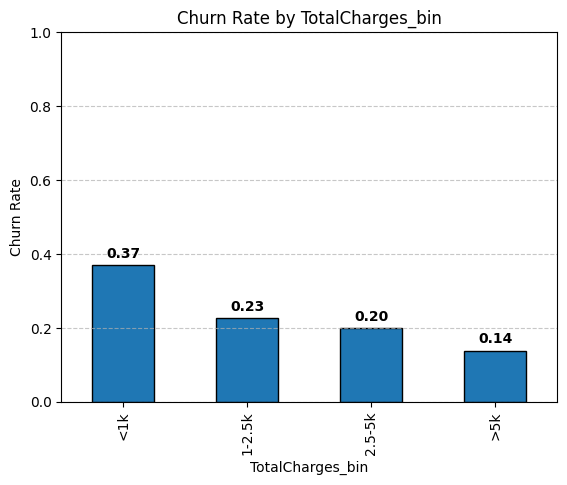

TotalCharges_bin
<1k       0.369858
1-2.5k    0.225944
2.5-5k    0.198972
>5k       0.138326
Name: Churn, dtype: float64

In [23]:
# TotalCharges bin
plot_churn_rate_by_bin(df, "TotalCharges_bin")

/tmp/ipykernel_1444/2287798146.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(bin_col)[target_col]


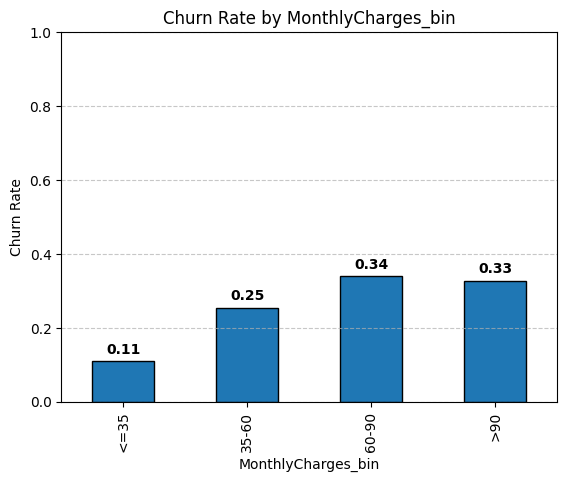

MonthlyCharges_bin
<=35     0.109312
35-60    0.254869
60-90    0.339488
>90      0.327775
Name: Churn, dtype: float64

In [24]:
# Monthlycharne bin
plot_churn_rate_by_bin(df, "MonthlyCharges_bin")

/tmp/ipykernel_1444/2287798146.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(bin_col)[target_col]


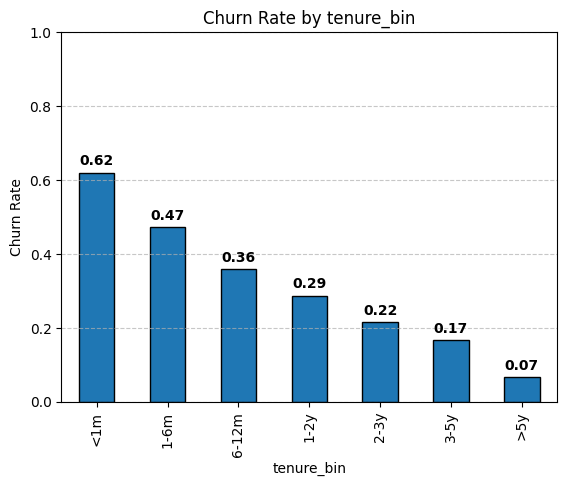

tenure_bin
<1m      0.619902
1-6m     0.471412
6-12m    0.358865
1-2y     0.287109
2-3y     0.216346
3-5y     0.166248
>5y      0.066098
Name: Churn, dtype: float64

In [25]:
# Ternure bin
plot_churn_rate_by_bin(df, "tenure_bin")

<Figure size 640x480 with 0 Axes>

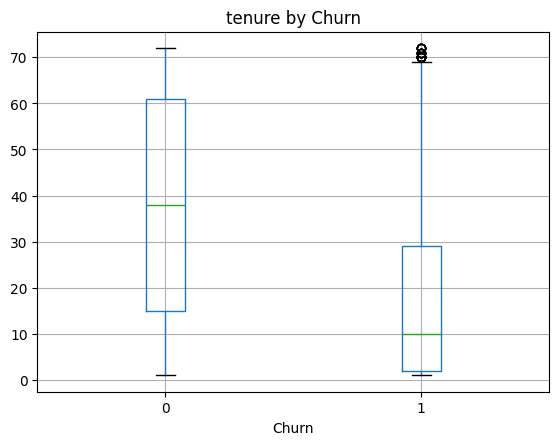

<Figure size 640x480 with 0 Axes>

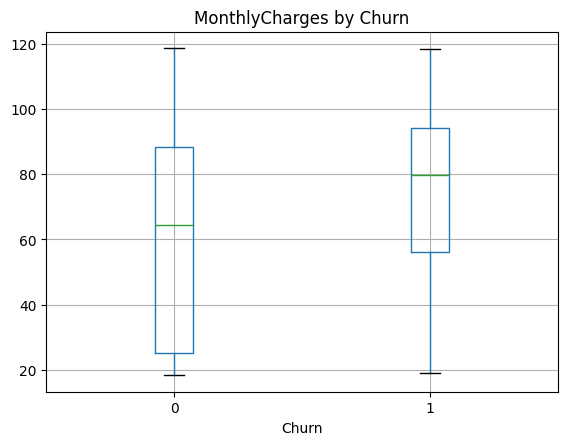

<Figure size 640x480 with 0 Axes>

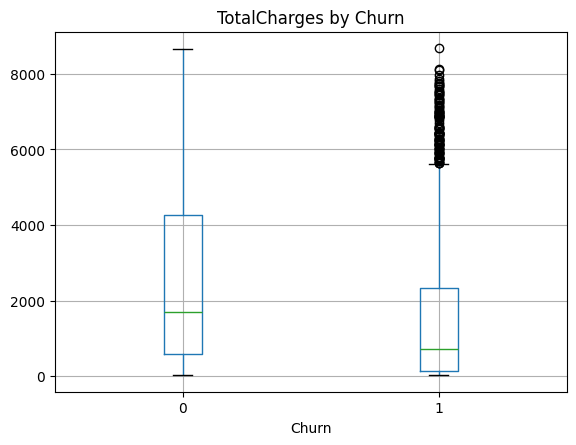

In [26]:
# Numeric vs target
for col in NUM_COLS:
    plt.figure()
    df.boxplot(column=col, by="Churn")
    plt.title(f"{col} by Churn")
    plt.suptitle("")
    plt.show()


In [27]:
def plot_correlation_matrix(df, cols=None, title="Correlation Matrix"):
    """
    Plot correlation matrix with values annotated.
    """
    if cols is None:
        cols = df.select_dtypes(include=np.number).columns

    corr = df[cols].corr()

    plt.figure(figsize=(6, 5))
    plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()

    ticks = np.arange(len(corr.columns))
    plt.xticks(ticks, corr.columns, rotation=45, ha="right")
    plt.yticks(ticks, corr.columns)

    # Plot text inside each cell
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                     ha='center', va='center',
                     color="black" if abs(corr.iloc[i, j]) < 0.7 else "white")

    plt.title(title)
    plt.tight_layout()
    plt.show()

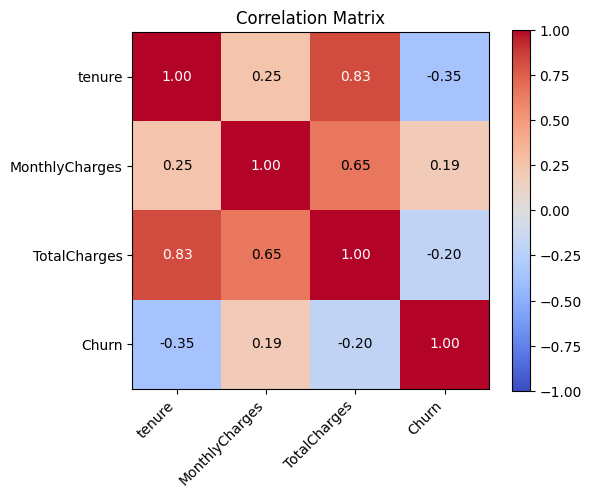

In [28]:
plot_correlation_matrix(df, cols=["tenure", "MonthlyCharges", "TotalCharges", "Churn"])

In [29]:
# ------------------------------------------------------------------
def _cramers_v(table: pd.DataFrame) -> float:
    """
    Cramér’s V effect-size for an RxC contingency table.
    """
    chi2 = chi2_contingency(table, correction=False)[0]
    n    = table.to_numpy().sum()
    r, k = table.shape
    return math.sqrt(chi2 / (n * (min(r, k) - 1))) if min(r, k) > 1 else 0.0

In [30]:
def _effect_label(v: float) -> str:
    """
    Qualitative label for Cramér’s V.
    """
    if   v < 0.10: return "negligible"
    elif v < 0.20: return "weak"
    elif v < 0.30: return "moderate"
    else:          return "strong"

In [31]:
def categorical_target_analysis(
    df: pd.DataFrame,
    target: str = "Churn",
    positive: str | int | bool = "Yes",
    cat_cols: list[str] | None = None,
    p_threshold: float = 0.05,
    v_threshold: float = 0.10,
) -> pd.DataFrame:
    """
    Evaluate association between each *categorical* feature and
    a *binary* target using a χ² test (or Fisher for small 2×2 tables).

    Returns a tidy DataFrame with:
    ─ feature            : column name
    ─ levels             : number of unique categories
    ─ p_value            : significance level
    ─ cramers_v          : effect-size (0–1)
    ─ effect_label       : qualitative strength
    ─ churn_rates        : {category: rate} dict rounded to 3 d.p.
    ─ decision           : "keep" if (p < p_threshold and V ≥ v_threshold)

    Parameters
    ----------
    df : pd.DataFrame
        Source dataframe.
    target : str
        Name of the binary target column.
    positive : str | int | bool
        Value considered as the positive class (defaults to "Yes").
    cat_cols : list[str] | None
        List of categorical columns to test.  If None, all object columns
        are used.
    p_threshold : float
        Significance cut-off for the hypothesis test.
    v_threshold : float
        Minimum Cramér’s V to consider the effect relevant.

    Returns
    -------
    pd.DataFrame
        Sorted by p-value ascending (most significant first).
    """
    work = df.copy()
    work[target] = (work[target] == positive).astype(int)

    if cat_cols is None:
        cat_cols = work.select_dtypes(include="object").columns.tolist()

    rows = []

    for col in cat_cols:
        if col == target:
            continue

        # contingency table: categories × target (0/1)
        table = pd.crosstab(work[col], work[target])

        # choose χ² or Fisher for 2×2 with small counts
        if table.shape == (2, 2) and (table < 5).any().any():
            _, p_val = fisher_exact(table)
        else:
            _, p_val, _, _ = chi2_contingency(table, correction=False)

        v  = _cramers_v(table)
        cr = (table[1] / table.sum(axis=1)).round(3).to_dict()

        keep = (p_val < p_threshold) and (v >= v_threshold)

        rows.append(
            dict(
                feature      = col,
                levels       = table.shape[0],
                p_value      = p_val,
                cramers_v    = v,
                effect_label = _effect_label(v),
                churn_rates  = cr,
                decision     = "keep" if keep else "drop",
            )
        )

    return (
        pd.DataFrame(rows)
        .sort_values("p_value")
        .reset_index(drop=True)
    )

In [32]:
summary = categorical_target_analysis(
    df,
    target="Churn",
    positive=1,
    cat_cols=CAT_COLS,    
    p_threshold=0.05,
    v_threshold=0.10,
)

In [33]:
print(summary.head(20)[["feature", "p_value", "cramers_v",
                        "effect_label", "decision"]])

             feature        p_value  cramers_v effect_label decision
0           Contract  7.326182e-257   0.409560       strong     keep
1     OnlineSecurity  1.400687e-184   0.346992       strong     keep
2        TechSupport  7.407808e-180   0.342506       strong     keep
3    InternetService  5.831199e-159   0.321909       strong     keep
4      PaymentMethod  1.426310e-139   0.302960       strong     keep
5       OnlineBackup  7.776099e-131   0.291902     moderate     keep
6   DeviceProtection  1.959389e-121   0.281159     moderate     keep
7    StreamingMovies   5.353560e-82   0.230702     moderate     keep
8        StreamingTV   1.324641e-81   0.230143     moderate     keep
9   PaperlessBilling   5.291852e-58   0.191454         weak     keep
10        Dependents   1.346800e-42   0.163128         weak     keep
11     SeniorCitizen   1.558566e-36   0.150541         weak     keep
12           Partner   2.824237e-36   0.149982         weak     keep
13     MultipleLines   3.567927e-0

In [34]:
selected_features = summary.loc[summary.decision == "keep",
                                "feature"].tolist()
print(f"\nSelected features ({len(selected_features)}):", selected_features)


Selected features (13): ['Contract', 'OnlineSecurity', 'TechSupport', 'InternetService', 'PaymentMethod', 'OnlineBackup', 'DeviceProtection', 'StreamingMovies', 'StreamingTV', 'PaperlessBilling', 'Dependents', 'SeniorCitizen', 'Partner']


# 4.0 Feature Engineering

In [35]:
def add_telco_features(
    df: pd.DataFrame,
    *,
    tenure_bins: Tuple[int, ...] = (-np.inf, 12, 24, 60, np.inf),
    tenure_labels: Tuple[str, ...] = ("<12", "12-24", "24-60", "60+"),
    charge_quantiles: Tuple[float, ...] = (0, .25, .50, .75, 1.0),
    charge_labels: Tuple[str, ...] = ("low", "mid-low", "mid-high", "high"),
) -> pd.DataFrame:
    """
    Return a copy of *df* with engineered Telco churn features.
    All original columns are preserved.

    Parameters
    ----------
    df : pd.DataFrame
        Raw Telco dataframe.
    tenure_bins, tenure_labels : tuple
        Bin edges & labels for tenure.
    charge_quantiles, charge_labels : tuple
        Quantile edges & labels for monthly charges.

    Returns
    -------
    pd.DataFrame
        Original + engineered columns.
    """
    X = df.copy()

    # ─ Social
    X["has_partner"]     = (X["Partner"] == "Yes").astype(int)
    X["has_dependents"]  = (X["Dependents"] == "Yes").astype(int)
    X["is_senior"]       = X["SeniorCitizen"].astype(int)
    X["social_score"]    = X["has_partner"] + X["has_dependents"] - X["is_senior"]

    # ─ Payment friction
    X["is_electronic_check"] = (X["PaymentMethod"] == "Electronic check").astype(int)
    X["is_automatic"]        = X["PaymentMethod"].str.contains(
        "automatic|credit", case=False, na=False
    ).astype(int)
    X["paperless_billing"]   = (X["PaperlessBilling"] == "Yes").astype(int)

    # ─ Contract
    m_map = {"Month-to-month": 1, "One year": 12, "Two year": 24}
    X["contract_months"]     = X["Contract"].map(m_map).fillna(1)
    X["is_monthly_contract"] = (X["contract_months"] == 1).astype(int)

    # ─ Products / services
    services = [
        "StreamingTV", "StreamingMovies",
        "OnlineSecurity", "OnlineBackup",
        "DeviceProtection", "TechSupport",
        "PhoneService", "MultipleLines"
    ]
    X["services_count"] = X[services].eq("Yes").sum(axis=1)

    X["has_streaming_pkg"] = (
        X[["StreamingTV", "StreamingMovies"]].eq("Yes").any(axis=1).astype(int)
    )
    online_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]
    X["has_online_pkg"] = X[online_cols].eq("Yes").any(axis=1).astype(int)

    # ─ Pricing
    X["monthly_charge"] = pd.to_numeric(X["MonthlyCharges"], errors="coerce")
    X["tenure_months"]  = pd.to_numeric(X["tenure"], errors="coerce")

    X["charge_tenure_ratio"] = (
        X["TotalCharges"].replace(" ", np.nan).astype(float)
        / X["tenure_months"].clip(lower=1)
    )
    X["avg_charge_per_service"] = (
        X["monthly_charge"] / X["services_count"].clip(lower=1)
    )

    # ─ Data-quality flag
    X["missing_total_charge"] = (
        X["TotalCharges"].astype(str).str.strip().eq("").astype(int)
    )

    # ─ Binning (categorical for OHE)
    X["tenure_bin"] = pd.cut(
        X["tenure_months"], bins=tenure_bins, labels=tenure_labels
    )
    X["monthly_charge_bin"] = pd.qcut(
        X["monthly_charge"], q=charge_quantiles, labels=charge_labels
    )

    return X

In [36]:
def add_telco_features(
    df: pd.DataFrame,
    *,
    tenure_bins: Tuple[int, ...] = (-np.inf, 12, 24, 60, np.inf),
    tenure_labels: Tuple[str, ...] = ("<12", "12-24", "24-60", "60+"),
    charge_quantiles: Tuple[float, ...] = (0, .25, .50, .75, 1.0),
    charge_labels: Tuple[str, ...] = ("low", "mid-low", "mid-high", "high"),
) -> pd.DataFrame:
    """
    Return a copy of *df* with engineered Telco churn features.
    All original columns are preserved.

    Parameters
    ----------
    df : pd.DataFrame
        Raw Telco dataframe.
    tenure_bins, tenure_labels : tuple
        Bin edges & labels for tenure.
    charge_quantiles, charge_labels : tuple
        Quantile edges & labels for monthly charges.

    Returns
    -------
    pd.DataFrame
        Original + engineered columns.
    """
    X = df.copy()

    # ─ Social
    X["has_partner"]     = (X["Partner"] == "Yes").astype(int)
    X["has_dependents"]  = (X["Dependents"] == "Yes").astype(int)
    X["is_senior"]       = X["SeniorCitizen"].astype(int)
    X["social_score"]    = X["has_partner"] + X["has_dependents"] - X["is_senior"]

    # ─ Payment friction
    X["is_electronic_check"] = (X["PaymentMethod"] == "Electronic check").astype(int)
    X["is_automatic"]        = X["PaymentMethod"].str.contains(
        "automatic|credit", case=False, na=False
    ).astype(int)
    X["paperless_billing"]   = (X["PaperlessBilling"] == "Yes").astype(int)

    # ─ Contract
    m_map = {"Month-to-month": 1, "One year": 12, "Two year": 24}
    X["contract_months"]     = X["Contract"].map(m_map).fillna(1)
    X["is_monthly_contract"] = (X["contract_months"] == 1).astype(int)

    # ─ Products / services
    services = [
        "StreamingTV", "StreamingMovies",
        "OnlineSecurity", "OnlineBackup",
        "DeviceProtection", "TechSupport",
        "PhoneService", "MultipleLines"
    ]
    X["services_count"] = X[services].eq("Yes").sum(axis=1)

    X["has_streaming_pkg"] = (
        X[["StreamingTV", "StreamingMovies"]].eq("Yes").any(axis=1).astype(int)
    )
    online_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport"]
    X["has_online_pkg"] = X[online_cols].eq("Yes").any(axis=1).astype(int)

    # ─ Pricing
    X["monthly_charge"] = pd.to_numeric(X["MonthlyCharges"], errors="coerce")
    X["tenure_months"]  = pd.to_numeric(X["tenure"], errors="coerce")

    X["charge_tenure_ratio"] = (
        X["TotalCharges"].replace(" ", np.nan).astype(float)
        / X["tenure_months"].clip(lower=1)
    )
    X["avg_charge_per_service"] = (
        X["monthly_charge"] / X["services_count"].clip(lower=1)
    )

    # ─ Data-quality flag
    X["missing_total_charge"] = (
        X["TotalCharges"].astype(str).str.strip().eq("").astype(int)
    )

    # ─ Binning (categorical for OHE)
    X["tenure_bin"] = pd.cut(
        X["tenure_months"], bins=tenure_bins, labels=tenure_labels
    )
    X["monthly_charge_bin"] = pd.qcut(
        X["monthly_charge"], q=charge_quantiles, labels=charge_labels
    )

    return X

In [37]:
def get_feature_lists() -> Tuple[List[str], List[str]]:
    """
    Return (numeric_cols, categorical_cols) used in the model pipeline.
    Adjust once here if you add/remove engineered variables.
    """
    numeric_cols = [
        "monthly_charge", "tenure_months", "services_count",
        "avg_charge_per_service", "charge_tenure_ratio",
        "social_score",
    ]

    categorical_cols = [
        "contract_months",        # treated as categorical for OHE
        "tenure_bin", "monthly_charge_bin",
        "is_monthly_contract",
        "has_streaming_pkg", "has_online_pkg",
        "is_electronic_check", "is_automatic", "paperless_billing",
        # binary flags = categorical → OHE(drop='first') effectively passes them
    ]
    return numeric_cols, categorical_cols

# ──────────────────────────────────────────────────────────
def build_preprocessor(
    *,
    numeric_cols: List[str] | None = None,
    categorical_cols: List[str] | None = None,
    ohe_drop: str = "first"
) -> ColumnTransformer:
    """
    Assemble a `ColumnTransformer` that one-hot-encodes categorical columns
    and passes numeric columns through unchanged.

    Parameters
    ----------
    numeric_cols : list or None
        If None, uses `get_feature_lists()`.
    categorical_cols : list or None
        Same rule as above.
    ohe_drop : str
        Option forwarded to `OneHotEncoder(drop=...)`.

    Returns
    -------
    sklearn.compose.ColumnTransformer
    """
    if numeric_cols is None or categorical_cols is None:
        num_default, cat_default = get_feature_lists()
        numeric_cols      = numeric_cols or num_default
        categorical_cols  = categorical_cols or cat_default

    return ColumnTransformer(
        transformers=[
            ("num", "passthrough", numeric_cols),
            ("ohe", OneHotEncoder(drop=ohe_drop, handle_unknown="ignore"), categorical_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

In [38]:
df_features = add_telco_features(df)

In [39]:
NUM_COLS_NEW = [
    "monthly_charge", "tenure_months", "services_count",
    "avg_charge_per_service", "charge_tenure_ratio",
    "social_score",
]

CAT_COLS_NEW = [
    "contract_months", "tenure_bin", "monthly_charge_bin",
    "is_monthly_contract", "has_streaming_pkg", "has_online_pkg",
    "is_electronic_check", "is_automatic", "paperless_billing",
]

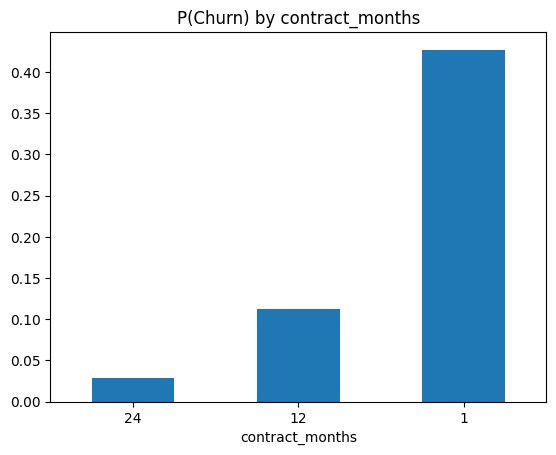

/tmp/ipykernel_1444/2667099293.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df_features.groupby(col)["Churn"]


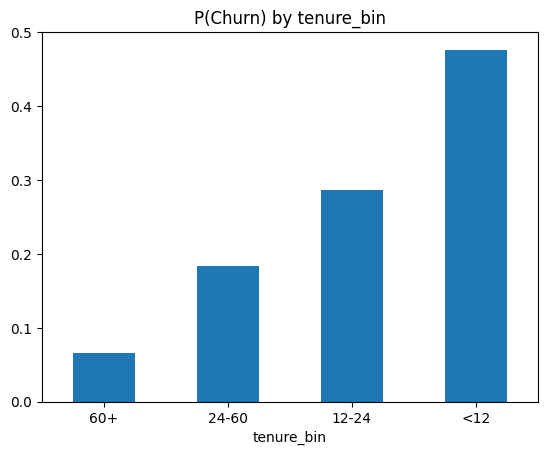

/tmp/ipykernel_1444/2667099293.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (df_features.groupby(col)["Churn"]


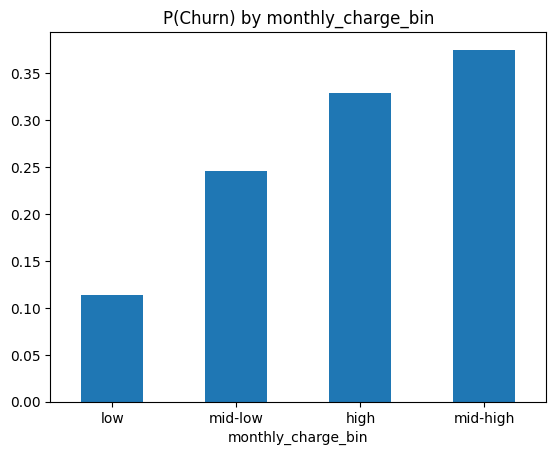

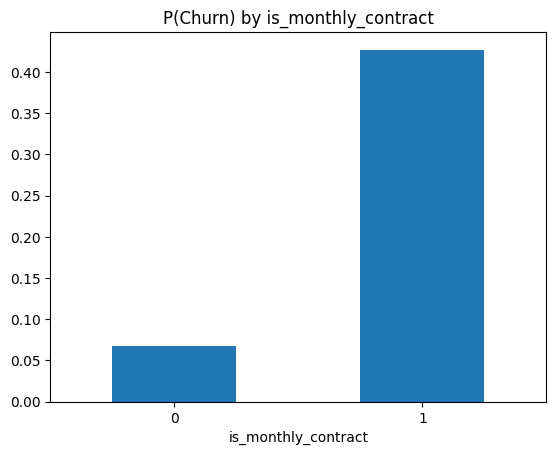

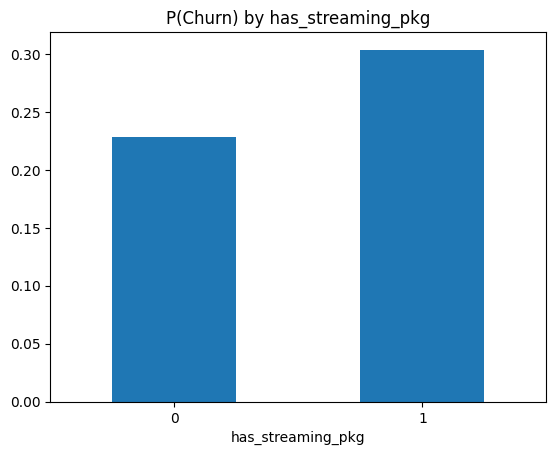

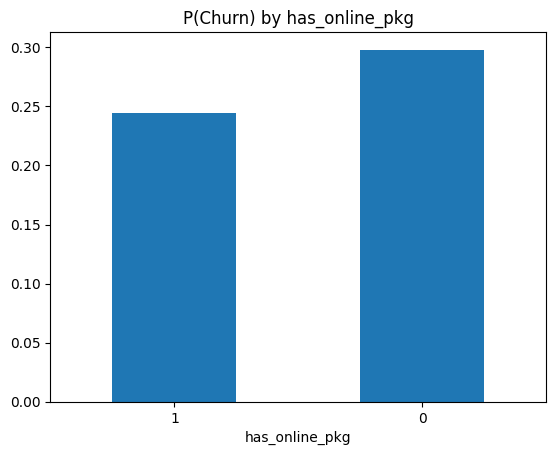

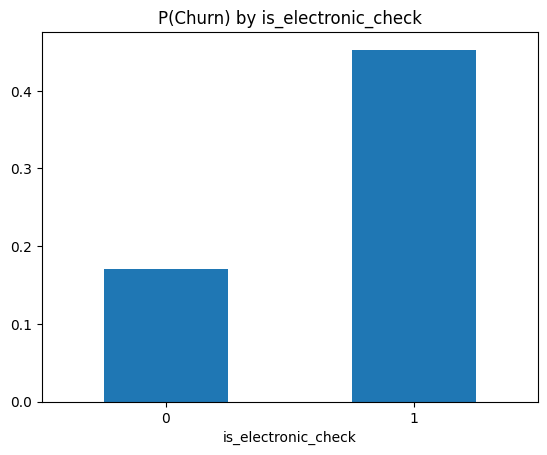

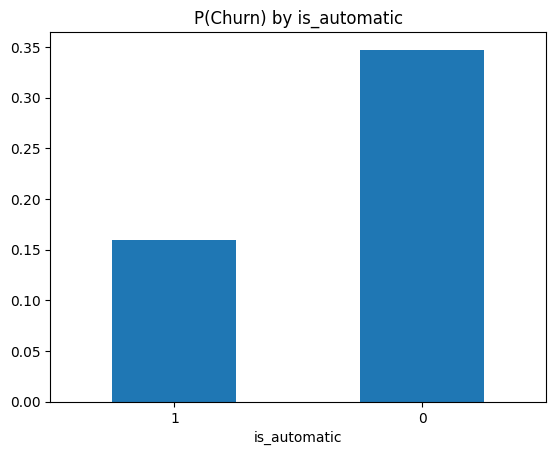

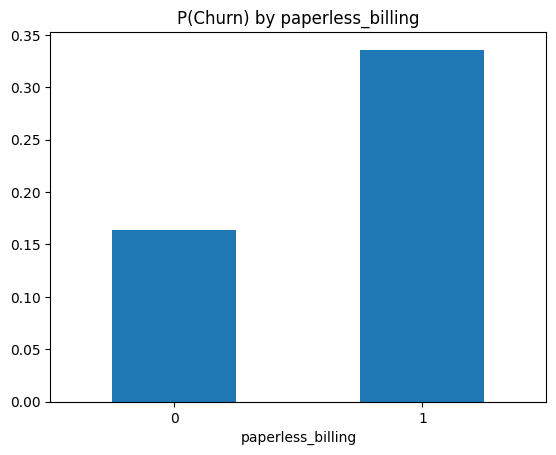

In [40]:
# Categorical vs target (stacked % bars)
for col in CAT_COLS_NEW:
    (df_features.groupby(col)["Churn"]
       .mean()
       .sort_values()
       .plot(kind="bar", rot=0, title=f"P(Churn) by {col}"))
    plt.show()

In [41]:
df_features

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin,tenure_bin,MonthlyCharges_bin,has_partner,has_dependents,is_senior,social_score,is_electronic_check,is_automatic,paperless_billing,contract_months,is_monthly_contract,services_count,has_streaming_pkg,has_online_pkg,monthly_charge,tenure_months,charge_tenure_ratio,avg_charge_per_service,missing_total_charge,monthly_charge_bin
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,<1k,<12,<=35,1,0,0,1,1,0,1,1,1,1,0,1,29.85,1,29.850000,29.850000,0,low
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1-2.5k,24-60,35-60,0,0,0,0,0,0,0,12,0,3,0,1,56.95,34,55.573529,18.983333,0,mid-low
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,<1k,<12,35-60,0,0,0,0,0,0,1,1,1,3,0,1,53.85,2,54.075000,17.950000,0,mid-low
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1-2.5k,24-60,35-60,0,0,0,0,0,1,0,12,0,3,0,1,42.30,45,40.905556,14.100000,0,mid-low
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,<1k,<12,60-90,0,0,0,0,1,0,1,1,1,1,0,0,70.70,2,75.825000,70.700000,0,mid-high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,1-2.5k,12-24,60-90,1,1,0,2,0,0,1,12,0,7,1,1,84.80,24,82.937500,12.114286,0,mid-high
7028,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,>5k,60+,>90,1,1,0,2,0,1,1,12,0,6,1,1,103.20,72,102.262500,17.200000,0,high
7029,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,<1k,<12,<=35,1,1,0,2,1,0,1,1,1,1,0,1,29.60,11,31.495455,29.600000,0,low
7030,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1,<1k,<12,60-90,1,0,1,0,0,0,1,1,1,2,0,0,74.40,4,76.650000,37.200000,0,mid-high


In [42]:
cat_summary = categorical_target_analysis(
    df_features,
    target="Churn",
    cat_cols=CAT_COLS_NEW,
    positive=1,
    p_threshold=0.05,
    v_threshold=0.10,
    
)

In [43]:
print(cat_summary.head(20)[["feature", "p_value", "cramers_v",
                        "effect_label", "decision"]])

               feature        p_value  cramers_v effect_label decision
0      contract_months  7.326182e-257   0.409560       strong     keep
1  is_monthly_contract  2.796009e-252   0.404565       strong     keep
2           tenure_bin  2.323620e-188   0.351821       strong     keep
3  is_electronic_check  5.425047e-141   0.301455       strong     keep
4   monthly_charge_bin   3.851172e-77   0.225423     moderate     keep
5         is_automatic   1.107672e-69   0.210420     moderate     keep
6    paperless_billing   5.291852e-58   0.191454         weak     keep
7    has_streaming_pkg   9.948830e-13   0.085040   negligible     drop
8       has_online_pkg   6.317854e-07   0.059402   negligible     drop


In [44]:
selected_cat = cat_summary.loc[cat_summary.decision == "keep", "feature"].tolist()
print("\nSelected categorical features:", selected_cat)


Selected categorical features: ['contract_months', 'is_monthly_contract', 'tenure_bin', 'is_electronic_check', 'monthly_charge_bin', 'is_automatic', 'paperless_billing']


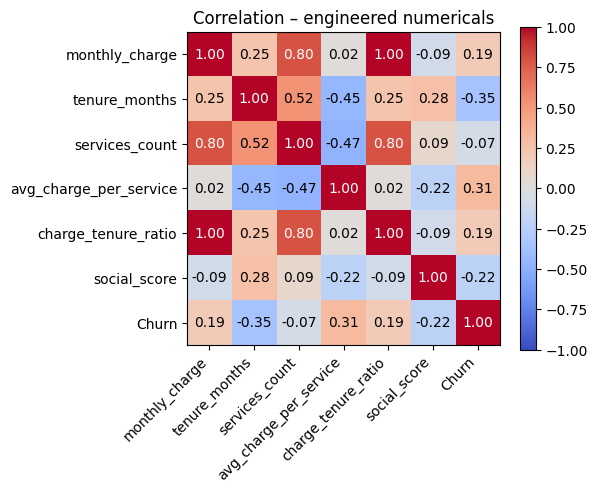

In [45]:
plot_correlation_matrix(
    df_features,
    cols=NUM_COLS_NEW + ["Churn"],
    title="Correlation – engineered numericals"
)

In [46]:
df_features["residual_charge"] = (
    df_features["monthly_charge"] -
    5.0 * df_features["services_count"]
)

In [50]:
df_features.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_bin,tenure_bin,MonthlyCharges_bin,has_partner,has_dependents,is_senior,social_score,is_electronic_check,is_automatic,paperless_billing,contract_months,is_monthly_contract,services_count,has_streaming_pkg,has_online_pkg,monthly_charge,tenure_months,charge_tenure_ratio,avg_charge_per_service,missing_total_charge,monthly_charge_bin,residual_charge
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,<1k,<12,<=35,1,0,0,1,1,0,1,1,1,1,0,1,29.85,1,29.850000,29.850000,0,low,24.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1-2.5k,24-60,35-60,0,0,0,0,0,0,0,12,0,3,0,1,56.95,34,55.573529,18.983333,0,mid-low,41.95


# 5.0 Model Benchmark & Cross-Validation 

In [ ]:
# ───────── RAW DATA ─────────
RAW_NUM = ["tenure", "MonthlyCharges", "TotalCharges"]
RAW_CAT = ["Contract", "InternetService",
           "PaymentMethod", "PaperlessBilling",
           "SeniorCitizen", "Partner", "Dependents"]

# ───────── FEATURE ENGINEERING ─────────
FE_NUM = [
    "monthly_charge", "services_count",
    "avg_charge_per_service", "social_score",
]
FE_CAT = [
    "contract_months", "tenure_bin", "monthly_charge_bin",
    "is_monthly_contract", "has_streaming_pkg", "has_online_pkg",
    "is_electronic_check", "is_automatic", "paperless_billing",
]

# ───────── MIX: RAW DATA + FEATURE ENGINEERING ─────────
MIX_NUM = ["tenure", "monthly_charge",
             "services_count", "avg_charge_per_service",
             "social_score"]

MIX_CAT = ["InternetService", "SeniorCitizen", "Partner", "Dependents",
             "contract_months", "tenure_bin", "monthly_charge_bin",
             "is_monthly_contract", "has_streaming_pkg", "has_online_pkg",
             "is_electronic_check", "is_automatic", "paperless_billing"]

In [78]:
# A) RAW-LITE
df_model_raw = df_features[RAW_NUM + RAW_CAT + ["Churn"]].copy()

# B) FEATURE-ENGINEERED
df_model_features = df_features[FE_NUM + FE_CAT + ["Churn"]].copy()

# C) MIX
df_model_mix = (
    df_features[RAW_NUM + RAW_CAT]          
    .join(df_features[FE_NUM + FE_CAT])  
    .assign(Churn=df_features["Churn"])       
)

DROP = ["TotalCharges",                 # cstrong correlation with tenure*monthly
        "PaperlessBilling",             # duplicated paperless_billing
        "MonthlyCharges",               # keep monthly_charge
        "Contract", "PaymentMethod"]    # replaced by new dummies
df_model_mix = df_model_mix.drop(columns=DROP)

In [60]:
def _safe_display_perf(perf: pd.DataFrame) -> None:
    """Pretty print with .style if Jinja2 is available, else plain text."""
    try:
        import jinja2  # noqa: F401
        display(
            perf.style.format(
                {"auc":"{:.3f}", "accuracy":"{:.3f}", "f1":"{:.3f}",
                 "precision":"{:.3f}", "recall":"{:.3f}", "log_loss":"{:.3f}"}
            )
        )
    except ModuleNotFoundError:
        print(perf.round(3).to_string(index=False))

In [ ]:
def evaluate_models(
    df: pd.DataFrame,
    num_cols: list[str],
    cat_cols: list[str],
    target_col: str = "Churn",
    test_size: float = 0.20,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Train a set of classifiers and return a leaderboard of metrics.
    Also plots ROC curves for the top-3 AUC models.

    Returns
    -------
    pd.DataFrame  –  sorted by AUC (descending).
    """
    # ─── train / test split ──────────────────────────────────────────
    X = df[num_cols + cat_cols]
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # ─── preprocessing ──────────────────────────────────────────────
    pre = ColumnTransformer(
        [("num", StandardScaler(), num_cols),
         ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
        remainder="drop",
        verbose_feature_names_out=False
    )

    # ─── model zoo ─────────────────────────────────────────────────
    models = {
        "LogReg"        : LogisticRegression(max_iter=1000, n_jobs=-1),
        "DecisionTree"  : DecisionTreeClassifier(random_state=random_state),
        "RandomForest"  : RandomForestClassifier(n_estimators=300,
                                                 random_state=random_state,
                                                 n_jobs=-1),
        "GradientBoost" : GradientBoostingClassifier(random_state=random_state),
        "AdaBoost"      : AdaBoostClassifier(random_state=random_state),
        "SVM-RBF"       : SVC(probability=True, random_state=random_state),
        "KNN"           : KNeighborsClassifier(),
        "XGBoost"       : XGBClassifier(
                              n_estimators=400, learning_rate=0.05,
                              max_depth=5, subsample=0.8, colsample_bytree=0.8,
                              eval_metric="logloss", random_state=random_state,
                              n_jobs=-1),
        "LightGBM"      : LGBMClassifier(
                              n_estimators=500, learning_rate=0.05,
                              objective="binary", random_state=random_state,
                              n_jobs=-1),
        "CatBoost"      : CatBoostClassifier(
                              iterations=500, learning_rate=0.05,
                              depth=6, verbose=False, random_state=random_state)
    }

    results, yhat_dict = [], {}             # store preds for ROC later

    for name, clf in models.items():
        tic = time.time()

        if name == "CatBoost":
            cat_idx = [X.columns.get_loc(c) for c in cat_cols]
            clf.fit(X_train, y_train, cat_features=cat_idx)
            y_prob = clf.predict_proba(X_test)[:, 1]
        else:
            pipe = Pipeline([("pre", pre), ("clf", clf)])
            pipe.fit(X_train, y_train)
            y_prob = pipe.predict_proba(X_test)[:, 1]

        y_pred = (y_prob >= 0.5).astype(int)
        elapsed = round(time.time() - tic, 2)

        yhat_dict[name] = y_prob            # store for ROC

        results.append({
            "model"      : name,
            "auc"        : roc_auc_score(y_test, y_prob),
            "accuracy"   : accuracy_score(y_test, y_pred),
            "f1"         : f1_score(y_test, y_pred),
            "precision"  : precision_score(y_test, y_pred),
            "recall"     : recall_score(y_test, y_pred),
            "log_loss"   : log_loss(y_test, y_prob),
            "train_secs" : elapsed,
        })

    perf = (
        pd.DataFrame(results)
        .sort_values("auc", ascending=False)
        .reset_index(drop=True)
    )

    print("\n=== Model leaderboard (test set) ===")
    _safe_display_perf(perf)

    # ─── ROC curves dos top-3 ──────────────────────────────────────
    top3 = perf.head(3)["model"]
    plt.figure(figsize=(6, 5))
    for name in top3:
        RocCurveDisplay.from_predictions(
            y_test, yhat_dict[name], name=name
        )
    plt.plot([0, 1], [0, 1], "k--", alpha=.4)
    plt.title("ROC curves – top-3 models")
    plt.tight_layout()
    plt.show()

    return perf

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


/home/sidnei/repos/telco_churn_case/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Model leaderboard (test set) ===
        model   auc  accuracy    f1  precision  recall  log_loss  train_secs
GradientBoost 0.835     0.796 0.574      0.645   0.516     0.428        1.18
       LogReg 0.834     0.802 0.596      0.650   0.551     0.428        1.66
     AdaBoost 0.834     0.795 0.569      0.643   0.511     0.516        0.35
     CatBoost 0.829     0.792 0.573      0.632   0.524     0.434        4.80
      XGBoost 0.817     0.778 0.548      0.596   0.508     0.455      231.53
     LightGBM 0.815     0.765 0.534      0.564   0.508     0.483     1099.88
 RandomForest 0.807     0.778 0.547      0.596   0.505     0.576        1.47
      SVM-RBF 0.793     0.792 0.541      0.656   0.460     0.469        4.05
          KNN 0.773     0.767 0.527      0.572   0.489     1.766        0.10
 DecisionTree 0.634     0.699 0.466      0.440   0.495    10.812        0.06


<Figure size 600x500 with 0 Axes>

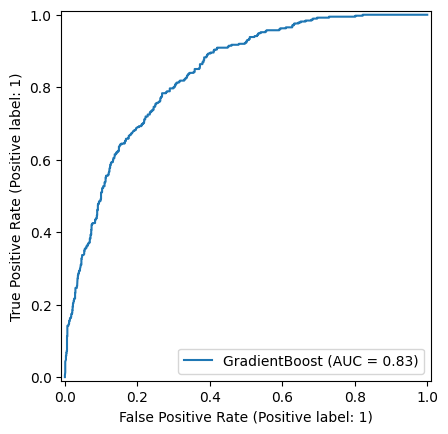

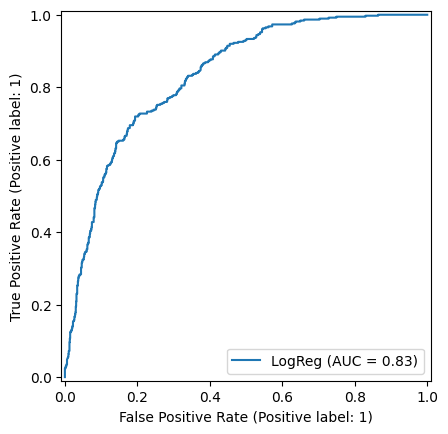

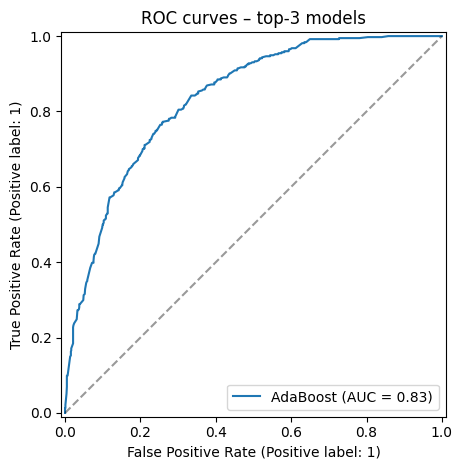

In [64]:
# ================= RAW-LITE
perf_raw = evaluate_models(df_model_raw,
                           num_cols=RAW_NUM,
                           cat_cols=RAW_CAT,
                           target_col="Churn")

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


/home/sidnei/repos/telco_churn_case/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Model leaderboard (test set) ===
        model   auc  accuracy    f1  precision  recall  log_loss  train_secs
     AdaBoost 0.833     0.795 0.573      0.640   0.519     0.523        0.35
GradientBoost 0.831     0.793 0.575      0.633   0.527     0.433        1.15
       LogReg 0.830     0.787 0.545      0.629   0.481     0.433        1.77
     CatBoost 0.827     0.787 0.554      0.626   0.497     0.438        4.74
      XGBoost 0.819     0.780 0.549      0.602   0.505     0.454      201.99
     LightGBM 0.810     0.768 0.537      0.573   0.505     0.485      827.13
      SVM-RBF 0.807     0.789 0.512      0.664   0.417     0.476        4.21
 RandomForest 0.797     0.773 0.548      0.581   0.519     0.633        1.30
          KNN 0.754     0.751 0.511      0.535   0.489     2.228        0.08
 DecisionTree 0.645     0.716 0.480      0.468   0.492    10.072        0.07


<Figure size 600x500 with 0 Axes>

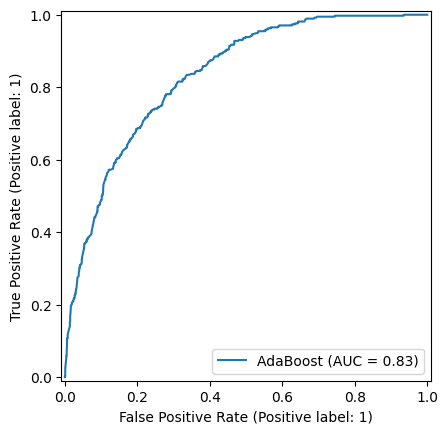

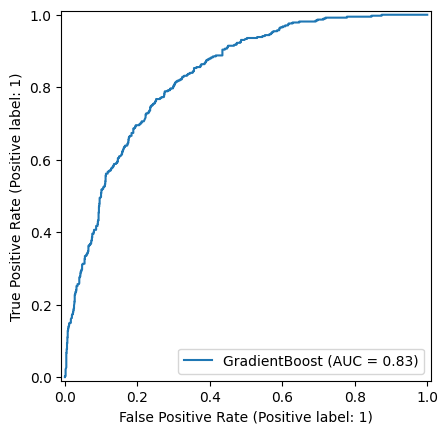

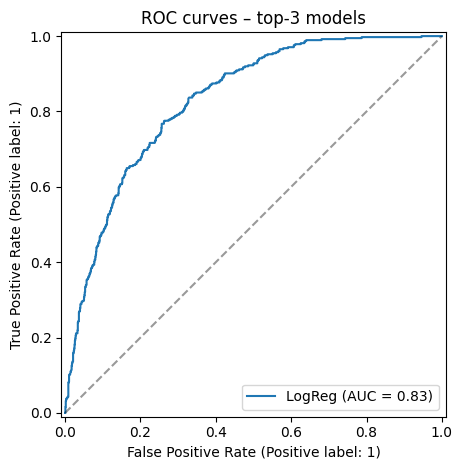

In [65]:
# ================= FEATURE-ENGINEERED
perf_features  = evaluate_models(df_model_features,
                           num_cols=FE_NUM,
                           cat_cols=FE_CAT,
                           target_col="Churn")

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


/home/sidnei/repos/telco_churn_case/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Model leaderboard (test set) ===
        model   auc  accuracy    f1  precision  recall  log_loss  train_secs
GradientBoost 0.836     0.798 0.581      0.648   0.527     0.429        1.31
     AdaBoost 0.833     0.799 0.578      0.653   0.519     0.516        0.38
       LogReg 0.832     0.790 0.559      0.634   0.500     0.431        2.03
     CatBoost 0.831     0.786 0.558      0.619   0.508     0.433        5.57
      XGBoost 0.820     0.786 0.559      0.618   0.511     0.450      225.67
     LightGBM 0.817     0.777 0.554      0.591   0.521     0.475     1081.37
      SVM-RBF 0.804     0.786 0.512      0.650   0.422     0.471        4.01
 RandomForest 0.804     0.774 0.553      0.583   0.527     0.535        1.35
          KNN 0.775     0.760 0.530      0.554   0.508     1.850        0.10
 DecisionTree 0.640     0.721 0.470      0.474   0.465     9.893        0.09


<Figure size 600x500 with 0 Axes>

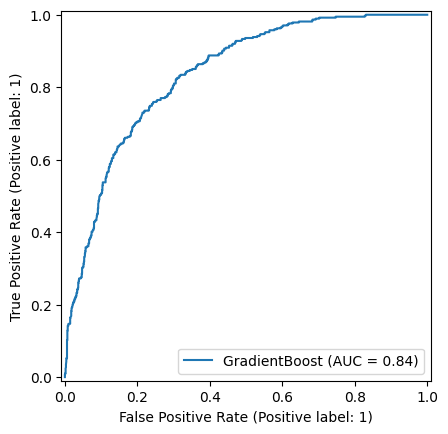

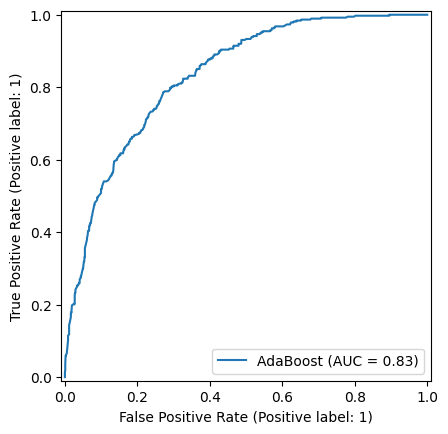

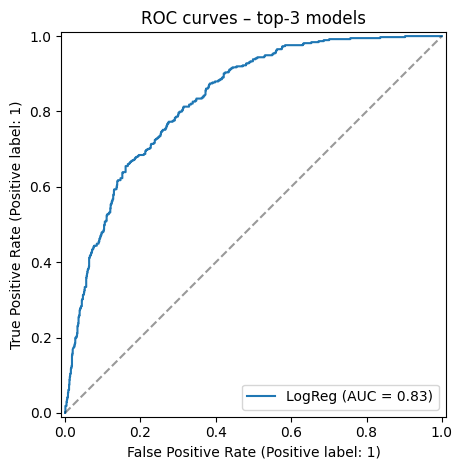

In [79]:
# ================= MIX
perf_mix = evaluate_models(df_model_mix,
                           num_cols=MIX_NUM,
                           cat_cols=MIX_CAT,
                           target_col="Churn")

In [80]:
leaderboard = pd.concat(
    [perf_raw.assign(dataset="raw"),
     perf_features.assign(dataset="features"),
     perf_mix.assign(dataset="mix")],
    ignore_index=True
)

In [81]:
with pd.option_context("display.max_rows", None,
                       "display.max_columns", None,
                       "display.precision", 3):
    display(leaderboard)

,model,auc,accuracy,f1,precision,recall,log_loss,train_secs,dataset
0,GradientBoost,0.835,0.796,0.574,0.645,0.516,0.428,1.18,raw
1,LogReg,0.834,0.802,0.596,0.650,0.551,0.428,1.66,raw
2,AdaBoost,0.834,0.795,0.569,0.643,0.511,0.516,0.35,raw
3,CatBoost,0.829,0.792,0.573,0.632,0.524,0.434,4.80,raw
4,XGBoost,0.817,0.778,0.548,0.596,0.508,0.455,231.53,raw
5,LightGBM,0.815,0.765,0.534,0.564,0.508,0.483,1099.88,raw
6,RandomForest,0.807,0.778,0.547,0.596,0.505,0.576,1.47,raw
7,SVM-RBF,0.793,0.792,0.541,0.656,0.460,0.469,4.05,raw
8,KNN,0.773,0.767,0.527,0.572,0.489,1.766,0.10,raw
9,DecisionTree,0.634,0.699,0.466,0.440,0.495,10.812,0.06,raw


In [88]:
leaderboard[leaderboard['model']=='GradientBoost']

,model,auc,accuracy,f1,precision,recall,log_loss,train_secs,dataset
0,GradientBoost,0.834979,0.796020,0.573551,0.645485,0.516043,0.427875,1.18,raw
11,GradientBoost,0.831375,0.793177,0.575182,0.633441,0.526738,0.432696,1.15,features
20,GradientBoost,0.835743,0.798152,0.581121,0.648026,0.526738,0.428508,1.31,mix


In [90]:
leaderboard[leaderboard['dataset']=='mix']

,model,auc,accuracy,f1,precision,recall,log_loss,train_secs,dataset
20,GradientBoost,0.835743,0.798152,0.581121,0.648026,0.526738,0.428508,1.31,mix
21,AdaBoost,0.832712,0.798863,0.578241,0.653199,0.518717,0.515582,0.38,mix
22,LogReg,0.831685,0.790334,0.559043,0.633898,0.500000,0.431313,2.03,mix
23,CatBoost,0.830993,0.786070,0.558003,0.618893,0.508021,0.433433,5.57,mix
24,XGBoost,0.820303,0.786070,0.559297,0.618123,0.510695,0.450355,225.67,mix
25,LightGBM,0.816818,0.776830,0.553977,0.590909,0.521390,0.474596,1081.37,mix
26,SVM-RBF,0.804030,0.786070,0.512156,0.650206,0.422460,0.471394,4.01,mix
27,RandomForest,0.803555,0.773987,0.553371,0.582840,0.526738,0.535160,1.35,mix
28,KNN,0.774807,0.760483,0.529986,0.553936,0.508021,1.850372,0.10,mix
29,DecisionTree,0.640271,0.720682,0.469636,0.474114,0.465241,9.892538,0.09,mix


In [83]:
df_model_mix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   tenure                  7032 non-null   int64   
 1   InternetService         7032 non-null   object  
 2   SeniorCitizen           7032 non-null   int8    
 3   Partner                 7032 non-null   object  
 4   Dependents              7032 non-null   object  
 5   monthly_charge          7032 non-null   float64 
 6   tenure_months           7032 non-null   int64   
 7   services_count          7032 non-null   int64   
 8   avg_charge_per_service  7032 non-null   float64 
 9   social_score            7032 non-null   int64   
 10  contract_months         7032 non-null   int64   
 11  tenure_bin              7032 non-null   category
 12  monthly_charge_bin      7032 non-null   category
 13  is_monthly_contract     7032 non-null   int64   
 14  has_streaming_pkg       

# 6.0 Hyper-Parameter Tuning

In [99]:
# feature lists
NUM = ["tenure","monthly_charge",
       "services_count","avg_charge_per_service","social_score"]
CAT = ["InternetService","SeniorCitizen","Partner","Dependents",
       "contract_months","tenure_bin","monthly_charge_bin",
       "is_monthly_contract","has_streaming_pkg","has_online_pkg",
       "is_electronic_check","is_automatic","paperless_billing"]


In [121]:
def tune_and_explain(
    df: pd.DataFrame,
    num_cols: List[str],
    cat_cols: List[str],
    target_col: str = "Churn",
    test_size: float = 0.20,
    random_state: int = 42,
    param_grid: Dict[str, List] | None = None,
    save_model_path: str | None = None,
    threshold_objective: str = "f1",          # "f1", "precision", or "recall"
    recall_target: float | None = None,       # needed if objective == "recall"
) -> Tuple[pd.DataFrame, Pipeline, float]:
    """
    Fine-tune GradientBoost, pick optimal threshold, plot SHAP, return results.

    Returns
    -------
    metrics_df : DataFrame (one row with AUC, F1, etc. at chosen threshold)
    best_pipe  : fitted Pipeline
    best_thr   : chosen probability cut-off
    """
    if param_grid is None:
        param_grid = {
            "clf__n_estimators": [300, 400, 600],
            "clf__learning_rate": [0.03, 0.05, 0.08],
            "clf__max_depth": [2, 3, 4],
        }

    # ─ split
    X = df[num_cols + cat_cols]
    y = df[target_col].values
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state)

    # ─ pipeline
    pre = ColumnTransformer(
        [("num", StandardScaler(), num_cols),
         ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
        verbose_feature_names_out=False)

    pipe = Pipeline([("pre", pre),
                     ("clf", GradientBoostingClassifier(random_state=random_state))])

    # ─ grid search
    gs = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc",
                      n_jobs=-1, verbose=0)

    tic = time.time()
    gs.fit(X_tr, y_tr)
    best_pipe  = gs.best_estimator_
    fit_secs   = round(time.time() - tic, 2)

    # ─ probability predictions
    y_prob = best_pipe.predict_proba(X_te)[:, 1]

    # ─ choose threshold via PR curve
    best_thr, pr_metrics = _choose_threshold(
        y_true=y_te,
        y_prob=y_prob,
        objective=threshold_objective,
        recall_target=recall_target,
        plot=True
    )
    y_pred = (y_prob >= best_thr).astype(int)

    # ─ evaluation
    metrics = {
        "AUC"        : roc_auc_score(y_te, y_prob),
        "F1"         : pr_metrics["f1"],
        "Precision"  : pr_metrics["precision"],
        "Recall"     : pr_metrics["recall"],
        "Log-loss"   : log_loss(y_te, y_prob),
        "Threshold"  : round(best_thr, 3),
        "Train_sec"  : fit_secs,
        "Best_params": gs.best_params_
    }
    metrics_df = pd.DataFrame([metrics])
    print("\n=== Test metrics (with tuned threshold) ===")
    print(metrics_df.round(3).to_string(index=False))

    # ─ ROC curve
    RocCurveDisplay.from_predictions(y_te, y_prob)
    plt.title("ROC – tuned GradientBoost"); plt.show()

    # ─ SHAP
    try:
        import shap
        explainer = shap.Explainer(best_pipe["clf"])
        X_te_tr = pd.DataFrame(
            best_pipe["pre"].transform(X_te),
            columns=best_pipe["pre"].get_feature_names_out())
        sv = explainer(X_te_tr, check_additivity=False)
        shap.summary_plot(sv, X_te_tr, plot_type="bar", show=False); plt.show()
        shap.summary_plot(sv, X_te_tr, show=False); plt.show()
    except ImportError:
        print("⚠️  SHAP not installed → pip install shap.")

    # ─ save model
    if save_model_path:
        joblib.dump({"model": best_pipe, "threshold": best_thr}, save_model_path)
        print(f"Model + threshold saved to {save_model_path}")

    return metrics_df, best_pipe, best_thr

In [124]:
def find_best_threshold(y_true, y_prob, objective="f1", recall_target=None):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1  = 2*prec*rec/(prec+rec+1e-8)

    if objective == "f1":
        idx = np.argmax(f1)
    elif objective == "precision":
        idx = np.argmax(prec)
    elif objective == "recall":
        if recall_target is None:
            raise ValueError("recall_target must be set for objective='recall'")
        cand = np.where(rec >= recall_target)[0]
        idx  = cand[np.argmax(prec[cand])]
    else:
        raise ValueError("objective must be 'f1', 'precision', or 'recall'")

    best_thr = thr[idx]
    metrics  = dict(threshold=round(best_thr,3),
                    precision=round(prec[idx],3),
                    recall   =round(rec[idx],3),
                    f1       =round(f1[idx],3))
    return best_thr, metrics

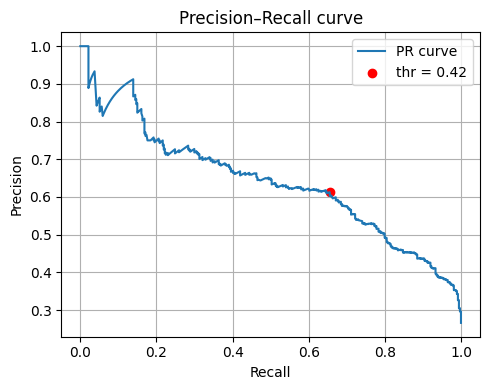


=== Test metrics (with tuned threshold) ===
  AUC    F1  Precision  Recall  Log-loss  Threshold  Train_sec                                                                 Best_params
0.837 0.633      0.612   0.655     0.425      0.424     181.81 {'clf__learning_rate': 0.03, 'clf__max_depth': 2, 'clf__n_estimators': 400}


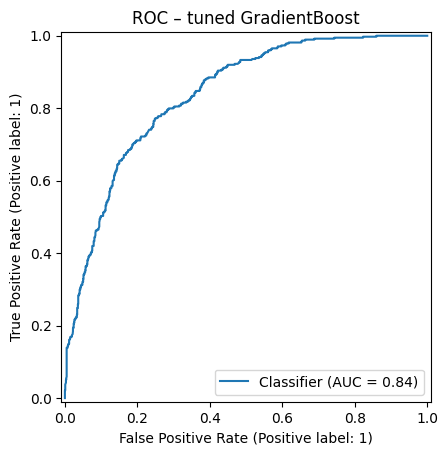

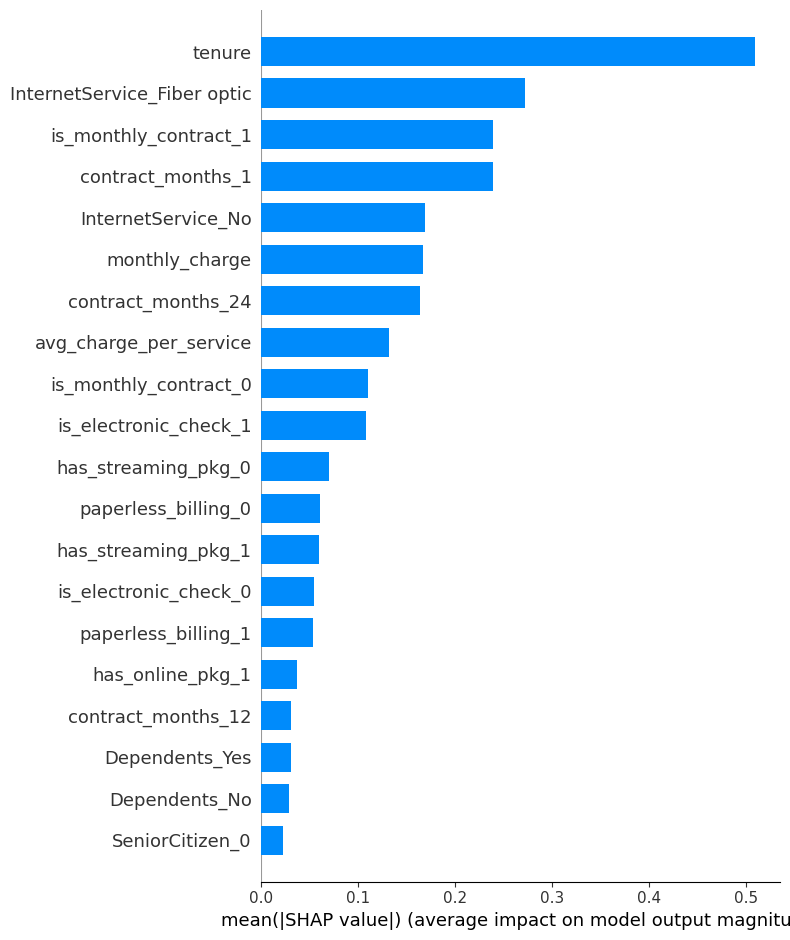

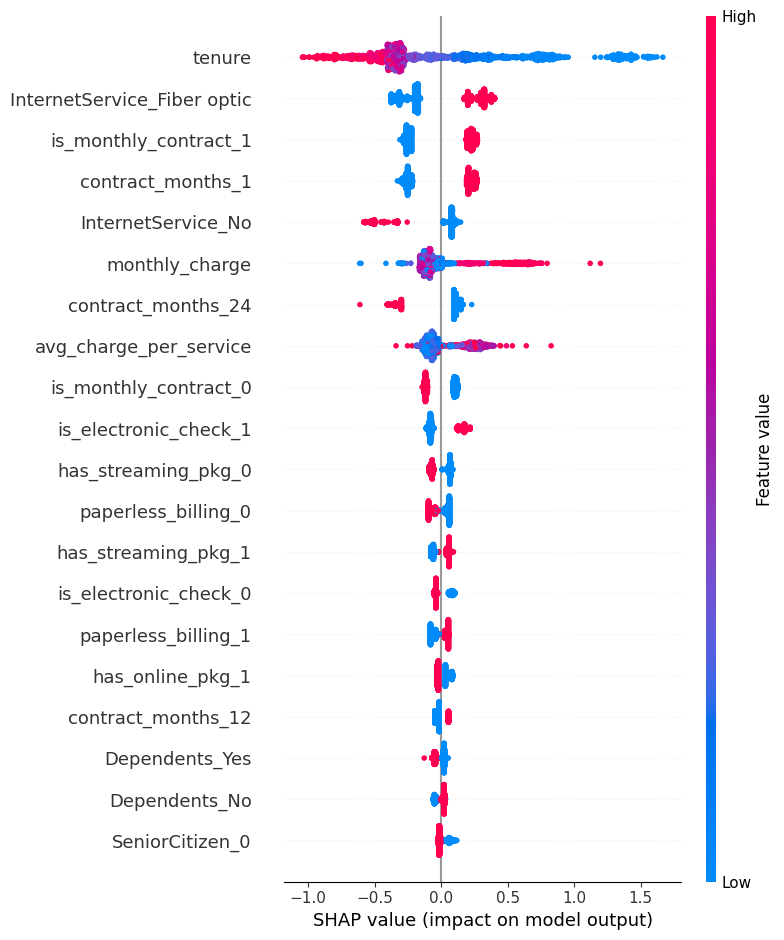

Model + threshold saved to /home/sidnei/repos/telco_churn_case/src/gboost_telco.pkl


In [123]:
metrics, best_model, best_thr = tune_and_explain(
    df           = df_model_mix,
    num_cols     = NUM,
    cat_cols     = CAT,
    target_col   = "Churn",
    save_model_path = "/home/sidnei/repos/telco_churn_case/src/gboost_telco.pkl"
)


In [125]:
to_save = {
    "pipeline"  : best_model,
    "threshold" : best_thr   
}

joblib.dump(to_save, "/home/sidnei/repos/telco_churn_case/src/gboost_telco.pkl")
print(f"✅ Model and threshold saved to: {"/home/sidnei/repos/telco_churn_case/src/gboost_telco.pkl"}")

✅ Model and threshold saved to: /home/sidnei/repos/telco_churn_case/src/gboost_telco.pkl


In [127]:
# To score new costumer later
#loaded = joblib.load("/home/sidnei/repos/telco_churn_case/src/gboost_telco.pkl")
#pipe      = loaded["pipeline"]
#cut_off   = loaded["threshold"]
#
#prob = pipe.predict_proba(new_customer_df)[:, 1][0]
#flag = prob >= cut_off

# 7.0 Business Sizing & Impact

In [187]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [ ]:
# --- 1. BASE METRICS pulled from the dataframe --------------------

BASE_CUSTOMERS   = df["customerID"].nunique()
CHURNERS_REAL    = df.loc[df["Churn"] == 1, "customerID"].nunique()
CHURN_RATE       = CHURNERS_REAL / BASE_CUSTOMERS
ARPU             = df["TotalCharges"].sum() / df["tenure"].sum()   # avg monthly
LTV_12M          = ARPU * 12                                        # 12-month LTV

COST_PER_CONTACT = 10       # $ per customer contacted
SUCCESS_RATE     = 0.30     # % of contacted churners you actually retain

In [209]:
def scenario_impact(recall: float, precision: float) -> dict:
    caught      = CHURNERS_REAL * recall
    contacted   = caught / precision
    cost        = contacted * COST_PER_CONTACT
    revenue     = caught * SUCCESS_RATE * LTV_12M
    roi         = revenue / cost if cost else float("inf")
    return {
        "Recall"          : round(recall, 3),
        "Precision"       : round(precision, 3),
        "Churners caught" : int(caught),
        "Contacts"        : int(contacted),
        "Cost ($)"       : round(cost, 0),
        "Revenue saved ($)": round(revenue, 0),
        "ROI (×)"         : round(roi, 1),
    }

In [210]:
scenarios = {
    "Baseline  (default thr 0.50)" : scenario_impact(recall=0.527, precision=0.648),
    "Fine-tuned (thr 0.50)"        : scenario_impact(recall=0.516, precision=0.612),
    "Fine-tuned (thr 0.424)"       : scenario_impact(recall=0.655, precision=0.612),
}

# --- 4. Pretty output ---------------------------------------------
print(f"=== CUSTOMER BASE ===")
print(f"Total customers : {BASE_CUSTOMERS:,}")
print(f"Observed churn  : {CHURN_RATE:.2%}")
print(f"Monthly ARPU    : $ {ARPU:,.2f}")
print(f"LTV (12-month)  : $ {LTV_12M:,.2f}\n")

for name, metrics in scenarios.items():
    print(f"--- {name} ---")
    for k, v in metrics.items():
        if "$" in k or k.endswith("($)"):
            print(f"{k:22}: $ {v:,.0f}")
        else:
            print(f"{k:22}: {v}")
    print()

=== CUSTOMER BASE ===
Total customers : 7,032
Observed churn  : 26.58%
Monthly ARPU    : $ 70.42
LTV (12-month)  : $ 845.10

--- Baseline  (default thr 0.50) ---
Recall                : 0.527
Precision             : 0.648
Churners caught       : 984
Contacts              : 1520
Cost ($)              : $ 15,200
Revenue saved ($)     : $ 249,717
ROI (×)               : 16.4

--- Fine-tuned (thr 0.50) ---
Recall                : 0.516
Precision             : 0.612
Churners caught       : 964
Contacts              : 1575
Cost ($)              : $ 15,758
Revenue saved ($)     : $ 244,505
ROI (×)               : 15.5

--- Fine-tuned (thr 0.424) ---
Recall                : 0.655
Precision             : 0.612
Churners caught       : 1224
Contacts              : 2000
Cost ($)              : $ 20,003
Revenue saved ($)     : $ 310,370
ROI (×)               : 15.5

